In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q transformers nlpaug albumentations emoji scikit-learn
!apt-get -qq install libxslt-dev

In [ ]:
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0 --quiet
import os
os._exit(00)

**STEP 1: Load & Preprocess Data**

In [ ]:
import pandas as pd
import os
import re
DATA_PATH = '/kaggle/input/kc-hasoc-2025/Hindi_train_2025_kc/Hindi_train_data.csv'
IMAGE_DIR = '/kaggle/input/kc-hasoc-2025/Hindi_train_2025_kc/Hindi_train_images/Hindi_train_images/'
df = pd.read_csv(DATA_PATH)
df.dropna(how='all', inplace=True)
df.drop_duplicates(inplace=True)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'@\w+', '', text)     
    text = re.sub(r'#\w+', '', text)     
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '', text)     
    text = re.sub(r'\s+', ' ', text).strip()
    return text
if 'OCR' in df.columns:
    df['clean_text'] = df['OCR'].apply(clean_text)
else:
    for col in df.columns:
        if df[col].dtype == 'object':
            df['clean_text'] = df[col].apply(clean_text)
            break
df['image_path'] = df['Ids'].astype(str).apply(lambda x: os.path.join(IMAGE_DIR, x + ".jpg"))
print(df.shape)
print(df.columns)
print(df[['clean_text', 'image_path']].head())


(1141, 9)
Index(['Ids', 'Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target', 'OCR',
       'clean_text', 'image_path'],
      dtype='object')
                                          clean_text  \
0  ba dann g ir t pdbb wrhe w prd bcen tt dian ci...   
1  nari nari mat kar pagle nari he nark ka dwar k...   
2  kitni push ops maarsakte ho dafly aur agar tum...   
3  अब इसम मर कह गलत ह बतओ तरबज़ वल क बल थड चड़ करक ...   
4  kudi menu kehndl menu juti la de soniye main k...   

                                          image_path  
0  /kaggle/input/kc-hasoc-2025/Hindi_train_2025_k...  
1  /kaggle/input/kc-hasoc-2025/Hindi_train_2025_k...  
2  /kaggle/input/kc-hasoc-2025/Hindi_train_2025_k...  
3  /kaggle/input/kc-hasoc-2025/Hindi_train_2025_k...  
4  /kaggle/input/kc-hasoc-2025/Hindi_train_2025_k...  


**STEP 2: OCR Extraction + Data Augmentation**

In [ ]:
import pytesseract
from PIL import Image
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
import random
import numpy as np
nltk.download('wordnet')
nltk.download('omw-1.4')
def extract_ocr_text(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        text = pytesseract.image_to_string(img, lang='hin+eng')  # Hindi + English
        return text.strip()
    except Exception as e:
        return ""
tqdm.pandas(desc="Extracting OCR")
df['ocr_text'] = df['image_path'].progress_apply(extract_ocr_text)
df['fused_text'] = df['clean_text'] + " " + df['ocr_text']
def synonym_augment(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym_words = [lemma.name() for lemma in synonyms[0].lemmas()]
            if synonym_words:
                synonym = synonym_words[0].replace("_", " ")
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return " ".join(new_words)
def augment_minority_classes(df, label_col, min_samples=150):
    counts = df[label_col].value_counts()
    minority_labels = counts[counts < min_samples].index.tolist()
    augmented_rows = []
    for label in minority_labels:
        subset = df[df[label_col] == label]
        needed = min_samples - len(subset)
        for _ in range(needed):
            row = subset.sample(1).iloc[0]
            augmented_text = synonym_augment(row['fused_text'])
            new_row = row.copy()
            new_row['fused_text'] = augmented_text
            augmented_rows.append(new_row)
    return pd.concat([df] + augmented_rows, ignore_index=True)
label_columns = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
df_aug = df.copy()
for col in label_columns:
    print(f" Augmenting: {col}")
    df_aug = augment_minority_classes(df_aug, col)

print(" Data augmentation complete. Final shape:", df_aug.shape)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Extracting OCR: 100%|██████████| 1141/1141 [00:00<00:00, 87236.39it/s]


🔁 Augmenting: Sentiment
🔁 Augmenting: Sarcasm
🔁 Augmenting: Vulgar
🔁 Augmenting: Abuse
🔁 Augmenting: Target
✅ Data augmentation complete. Final shape: (6267, 12)


In [ ]:
!pip install -U --quiet scikit-learn==1.3.2 imbalanced-learn==0.11.0

**STEP 3: Joint Oversampling with Stringified Labels:**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import joblib
import os
df = pd.read_csv("/kaggle/input/kc-hasoc-2025/Hindi_train_2025_kc/Hindi_train_data.csv")
df['OCR'] = df['OCR'].fillna("")
df['fused_text'] = (df['OCR'] + " " + df['OCR']).str.strip()
df['image_path'] = df['Ids'].astype(str).apply(lambda x: f"Hindi_train_images/{x.replace('.jpg.jpg', '').replace('.jpg','')}.jpg")
label_columns = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
encoders = {}
for col in label_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    joblib.dump(le, f"/kaggle/working/enc_{col}.pkl")
df['multi_label_str'] = df[label_columns].astype(str).agg('_'.join, axis=1)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled_str = ros.fit_resample(df[['fused_text', 'image_path']], df['multi_label_str'])
y_df = pd.DataFrame([list(map(int, lbl.split('_'))) for lbl in y_resampled_str], columns=label_columns)
X_resampled.reset_index(drop=True, inplace=True)
resampled_df = pd.concat([X_resampled, y_df], axis=1)
resampled_df.to_csv("/kaggle/working/joint_resampled.csv", index=False)
np.save("/kaggle/working/multilabel_encoded_targets.npy", y_df.to_numpy())
print("STEP 3 Completed Successfully:")
print(f"   ➤ Saved: joint_resampled.csv | Shape: {resampled_df.shape}")
print(f"   ➤ Labels saved as multilabel_encoded_targets.npy | Shape: {y_df.shape}")

ModuleNotFoundError: No module named 'sklearn.utils._metadata_requests'

****

In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/working/joint_resampled.csv")

label_cols = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
assert all(col in df.columns for col in label_cols), " Some label columns are missing"

df["joint_label"] = df[label_cols].values.tolist()

df.to_csv("/kaggle/working/joint_resampled.csv", index=False)
print("Added 'joint_label' column and saved updated CSV.")

df.head()

✅ Added 'joint_label' column and saved updated CSV.


,fused_text,image_path,Sentiment,Sarcasm,Vulgar,Abuse,Target,joint_label
0,Ba8@ DaNn G@rainiD IR T३ PDBB WRHE W PRD BCEN ...,Hindi_train_images/Hindi_image_1817.jpg,1,1,1,0,0,"[1, 1, 1, 0, 0]"
1,"Nari nari mat kar pagle, Nari he nark ka dwar....",Hindi_train_images/Hindi_image_7.jpg,0,0,1,0,0,"[0, 0, 1, 0, 0]"
2,Kitni push ops maarsakte ho dafly? 5 aur agar ...,Hindi_train_images/Hindi_image_1.jpg,2,1,0,0,0,"[2, 1, 0, 0, 0]"
3,अब इसमें मेरी कहां गलती है बताओ.. तरबूज़ वाली क...,Hindi_train_images/Hindi_image_32.jpg,0,1,1,0,0,"[0, 1, 1, 0, 0]"
4,"""KUDI MENU KEHNDl... 'MENU JUTI LA DE SONIYE.....",Hindi_train_images/Hindi_image_1714.jpg,0,1,0,0,0,"[0, 1, 0, 0, 0]"


In [ ]:

import os
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BeitImageProcessor, BeitModel
from PIL import Image
from tqdm import tqdm
import joblib

df = pd.read_csv("/kaggle/working/joint_resampled.csv")
df['fused_text'] = df['fused_text'].fillna("")
df['image_name'] = df['image_path'].apply(lambda x: os.path.basename(x))
image_folder = "/kaggle/input/kc-hasoc-2025/Hindi_train_2025_kc/Hindi_train_images/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased").to(device)
bert_model.eval()

beit_processor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")
beit_model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224").to(device)
beit_model.eval()

def extract_bert_features(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # [CLS]

def extract_beit_features(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = beit_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = beit_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # [CLS]
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return np.zeros(768)

X_features = []
y_labels = []

for i, row in tqdm(df.iterrows(), total=len(df), desc="🔄 Extracting features"):
    ocr_text = row["fused_text"]
    img_path = os.path.join(image_folder, row["image_name"])
    
    bert_feat = extract_bert_features(ocr_text)
    beit_feat = extract_beit_features(img_path)

    fused_feat = np.concatenate([bert_feat, beit_feat])  # (768 + 768) = 1536-dim
    X_features.append(fused_feat)
    
    label = eval(row["joint_label"])  # stringified label list -> actual list
    y_labels.append(label)

X_np = np.stack(X_features)  # shape: (7168, 1536)
y_np = np.stack(y_labels)    # shape: (7168, 5)

np.save("/kaggle/working/X_joint_fused.npy", X_np)
np.save("/kaggle/working/y_joint_labels.npy", y_np)

print(" Saved: X shape =", X_np.shape, "| y shape =", y_np.shape)


2025-06-27 04:44:50.547569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750999490.788149      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750999490.856826      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

🔄 Extracting features: 100%|██████████| 7168/7168 [04:26<00:00, 26.90it/s]

✅ Saved: X shape = (7168, 1536) | y shape = (7168, 5)


**# STEP 4: Load Resampled Data**

In [2]:
# STEP 4: Load Resampled Data
import numpy as np
import torch

# Load from saved files (from corrected Step 3)
X_np = np.load("/kaggle/working/X_joint_fused.npy")
y_np = np.load("/kaggle/working/y_joint_labels.npy")

assert X_np.shape[0] == y_np.shape[0], "Mismatch in data sizes"
print(f"✅ Loaded: X: {X_np.shape}, y: {y_np.shape}")


✅ Loaded: X: (7168, 1536), y: (7168, 5)


**STEP 5: Convert to PyTorch Tensors**

In [3]:
# STEP 5: Convert to PyTorch Tensors
X_tensor = torch.tensor(X_np, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.long)

# Sanity check
assert X_tensor.shape[0] == y_tensor.shape[0], "Tensor shape mismatch"
print("✅ Tensor conversion successful")

✅ Tensor conversion successful


**STEP 6: Dataset Splitting**

In [ ]:

from torch.utils.data import TensorDataset, DataLoader, random_split


dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f" Dataset split: Train={train_size}, Val={val_size}")

✅ Dataset split: Train=5734, Val=1434


**STEP 7: Multitask Fusion Classifier with Class-Balanced Loss**

In [5]:
# STEP 7: Multitask Fusion Classifier with Class-Balanced Loss
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

# === Model Definition ===
class FusionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(FusionClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.heads = nn.ModuleList([nn.Linear(hidden_dim, c) for c in num_classes])

    def forward(self, x):
        x = self.relu(self.fc(x))
        return [head(x) for head in self.heads]

# === Class-Balanced Loss Weights ===
y_train = y_tensor[:train_size]
loss_fns = []
num_classes = []

for i in range(y_train.shape[1]):
    y_i = y_train[:, i].numpy()
    classes = np.unique(y_i)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_i)
    weight_tensor = torch.tensor(weights, dtype=torch.float32)
    loss_fns.append(nn.CrossEntropyLoss(weight=weight_tensor))
    num_classes.append(len(classes))

# === Initialize Model and Optimizer ===
model = FusionClassifier(input_dim=1536, hidden_dim=512, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Training Loop ===
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = sum(loss_fns[i](outputs[i], y_batch[:, i]) for i in range(len(outputs)))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# === Evaluation Function ===
from sklearn.metrics import classification_report

def evaluate(model, loader):
    model.eval()
    all_preds = [[] for _ in range(len(loss_fns))]
    all_labels = [[] for _ in range(len(loss_fns))]
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            for i, output in enumerate(outputs):
                preds = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(preds)
                all_labels[i].extend(y_batch[:, i].cpu().numpy())
    for i, name in enumerate(["Sentiment", "Sarcasm", "Vulgar", "Abuse", "Target"]):
        print(f"\n📊 {name} Report:")
        print(classification_report(all_labels[i], all_preds[i], digits=2))

# === Full Training ===
for epoch in range(5):
    train_loss = train_one_epoch(model, train_loader)
    print(f"\n📘 Epoch {epoch+1}: Train Loss = {train_loss:.4f}")
    evaluate(model, val_loader)


📘 Epoch 1: Train Loss = 8.7464

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.96      0.04      0.08       547
           1       0.46      0.03      0.05       464
           2       0.30      0.99      0.46       423

    accuracy                           0.32      1434
   macro avg       0.57      0.35      0.20      1434
weighted avg       0.60      0.32      0.18      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       668
           1       0.61      0.88      0.72       766

    accuracy                           0.64      1434
   macro avg       0.67      0.62      0.61      1434
weighted avg       0.67      0.64      0.61      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       718
           1       0.65      0.66      0.66       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📘 Epoch 3: Train Loss = 4.1729

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.73      0.21      0.33       547
           1       0.00      0.00      0.00       464
           2       0.32      0.98      0.49       423

    accuracy                           0.37      1434
   macro avg       0.35      0.40      0.27      1434
weighted avg       0.38      0.37      0.27      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.87      0.30      0.45       668
           1       0.61      0.96      0.75       766

    accuracy                           0.65      1434
   macro avg       0.74      0.63      0.60      1434
weighted avg       0.73      0.65      0.61      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       718
           1       0.76      0.72      0.74       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📘 Epoch 4: Train Loss = 3.8798

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.65      0.48      0.55       547
           1       0.89      0.23      0.37       464
           2       0.42      0.90      0.58       423

    accuracy                           0.53      1434
   macro avg       0.65      0.54      0.50      1434
weighted avg       0.66      0.53      0.50      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.91      0.27      0.42       668
           1       0.61      0.98      0.75       766

    accuracy                           0.65      1434
   macro avg       0.76      0.63      0.58      1434
weighted avg       0.75      0.65      0.60      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       718
           1       0.70      0.90      0.79       716

    accuracy                          

**Updated Step 7 and combine with Step 8: Training + Saving + Evaluation + Visualizations**

## What this version includes:
- ✅ Early stopping (monitors val F1)
- ✅ Model checkpoint saving (best_model.pt)
- ✅ Classification reports per head
- ✅ Confusion matrices per head
- ✅ Inline plots and saved .png files
- ✅ F1 score bar chart

In [11]:
pip install torch-focal

ERROR: Could not find a version that satisfies the requirement torch-focal (from versions: none)
ERROR: No matching distribution found for torch-focal
Note: you may need to restart the kernel to use updated packages.



📘 Epoch 1: Train Loss = 3.4105
🎯 Val Macro F1 = 0.6817
✅ Model checkpoint saved.

📘 Epoch 2: Train Loss = 3.2464
🎯 Val Macro F1 = 0.6873

📘 Epoch 3: Train Loss = 3.1504
🎯 Val Macro F1 = 0.7181
⏹️ Early stopping triggered.

✅ Loading best model and generating reports...

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.72      0.52      0.60       566
           1       0.82      0.37      0.51       450
           2       0.46      0.91      0.61       418

    accuracy                           0.59      1434
   macro avg       0.67      0.60      0.58      1434
weighted avg       0.67      0.59      0.58      1434

📌 Confusion Matrix for Sentiment


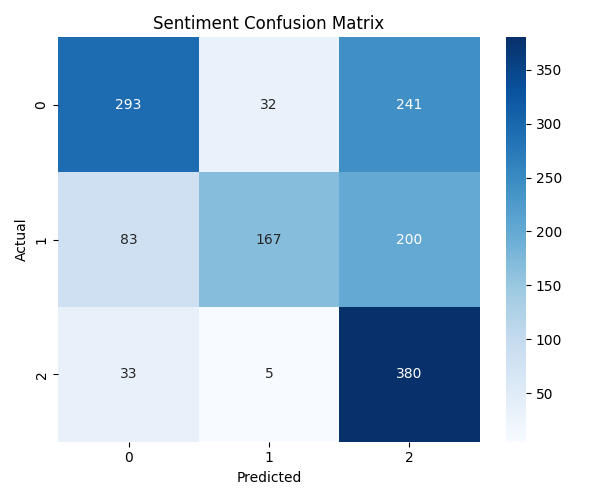


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.89      0.46      0.60       662
           1       0.67      0.95      0.79       772

    accuracy                           0.72      1434
   macro avg       0.78      0.70      0.70      1434
weighted avg       0.77      0.72      0.70      1434

📌 Confusion Matrix for Sarcasm


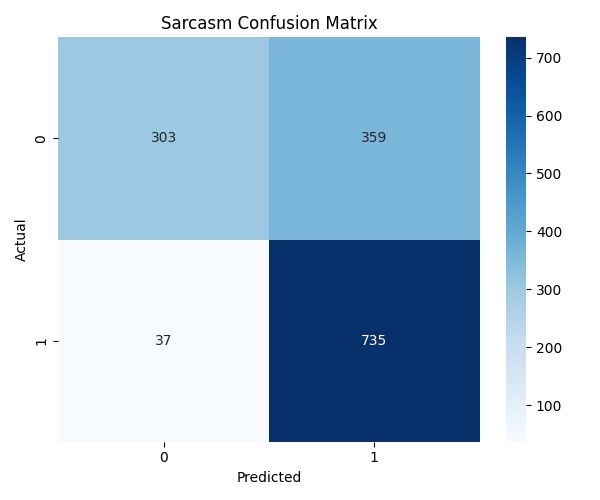


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       758
           1       0.76      0.87      0.81       676

    accuracy                           0.81      1434
   macro avg       0.81      0.81      0.81      1434
weighted avg       0.82      0.81      0.81      1434

📌 Confusion Matrix for Vulgar


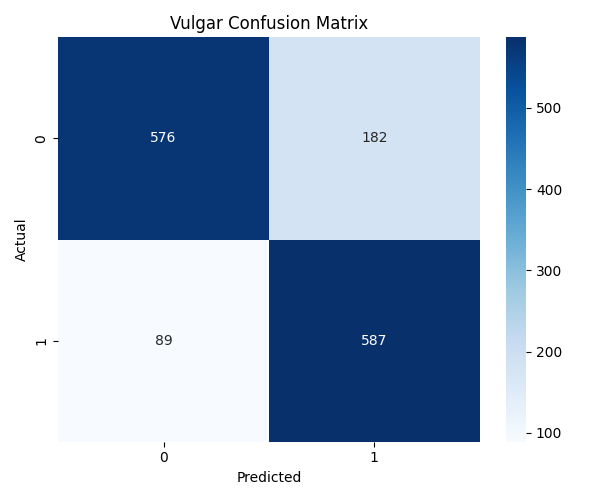


📊 Abuse Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       566
           1       0.89      0.76      0.82       868

    accuracy                           0.80      1434
   macro avg       0.79      0.81      0.79      1434
weighted avg       0.81      0.80      0.80      1434

📌 Confusion Matrix for Abuse


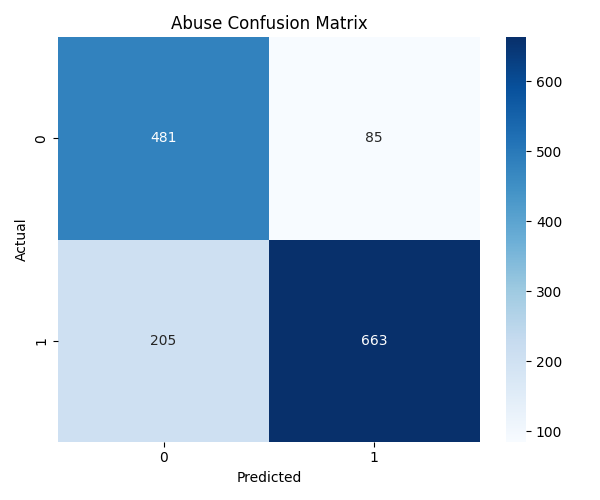


📊 Target Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       252
           1       0.83      0.21      0.34       261
           2       0.29      0.97      0.44        70
           3       0.31      0.74      0.44       214
           4       0.69      0.84      0.76       145
           5       0.84      1.00      0.91        58
           6       0.97      0.32      0.48       183
           7       0.71      0.15      0.24       251

    accuracy                           0.50      1434
   macro avg       0.66      0.61      0.53      1434
weighted avg       0.67      0.50      0.48      1434

📌 Confusion Matrix for Target


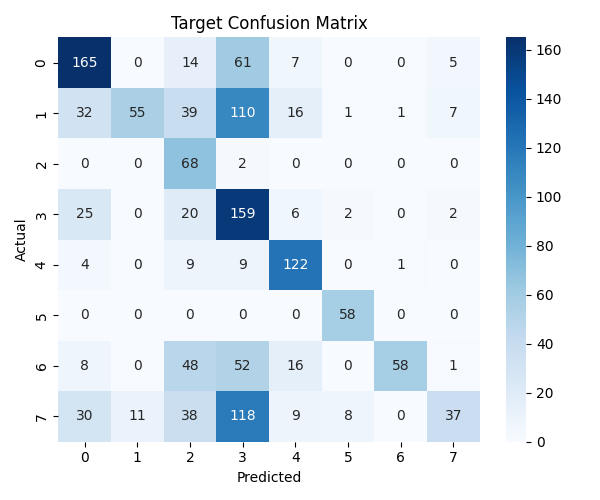


📌 Macro F1 Score Chart:


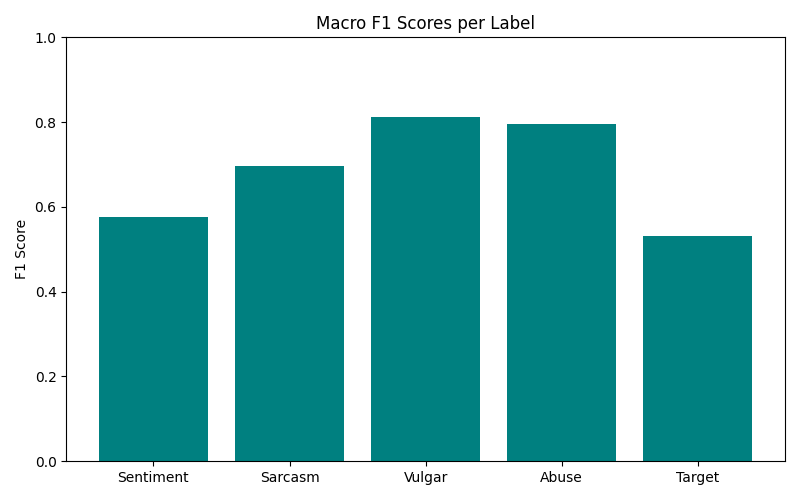

✅ All evaluation results saved to: /kaggle/working/eval_reports


**Step 7 (Improved): Training Pipeline with SelfAttentionFusion**


📘 Epoch 1: Train Loss = 5.1479
📈 Avg Macro F1 = 0.2844
✅ Best model saved

📘 Epoch 2: Train Loss = 5.0433
📈 Avg Macro F1 = 0.3360
✅ Best model saved

📘 Epoch 3: Train Loss = 4.6968
📈 Avg Macro F1 = 0.4405
✅ Best model saved

📘 Epoch 4: Train Loss = 4.2438
📈 Avg Macro F1 = 0.5205
✅ Best model saved

📘 Epoch 5: Train Loss = 3.6622
📈 Avg Macro F1 = 0.5934
✅ Best model saved

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.56      0.30      0.39       547
           1       0.97      0.07      0.13       464
           2       0.37      0.98      0.54       423

    accuracy                           0.43      1434
   macro avg       0.63      0.45      0.35      1434
weighted avg       0.64      0.43      0.35      1434

📌 Confusion Matrix for Sentiment


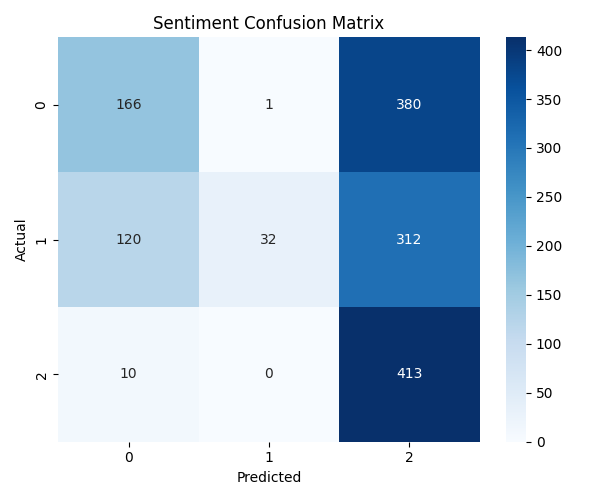


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.87      0.40      0.55       668
           1       0.65      0.95      0.77       766

    accuracy                           0.69      1434
   macro avg       0.76      0.68      0.66      1434
weighted avg       0.75      0.69      0.67      1434

📌 Confusion Matrix for Sarcasm


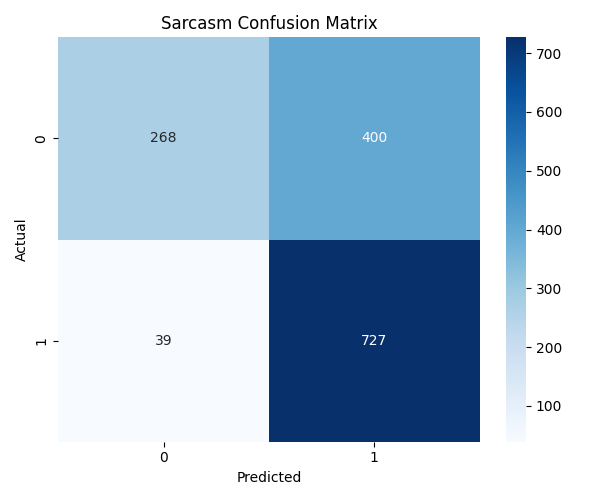


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       718
           1       0.75      0.79      0.77       716

    accuracy                           0.76      1434
   macro avg       0.76      0.76      0.76      1434
weighted avg       0.76      0.76      0.76      1434

📌 Confusion Matrix for Vulgar


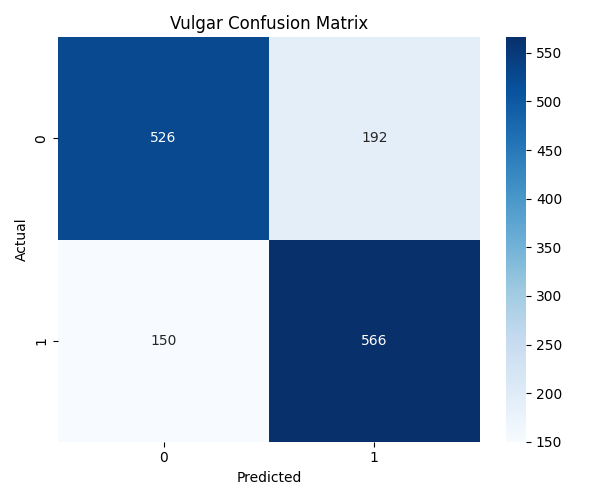


📊 Abuse Report:
              precision    recall  f1-score   support

           0       0.84      0.44      0.58       571
           1       0.72      0.95      0.82       863

    accuracy                           0.74      1434
   macro avg       0.78      0.69      0.70      1434
weighted avg       0.77      0.74      0.72      1434

📌 Confusion Matrix for Abuse


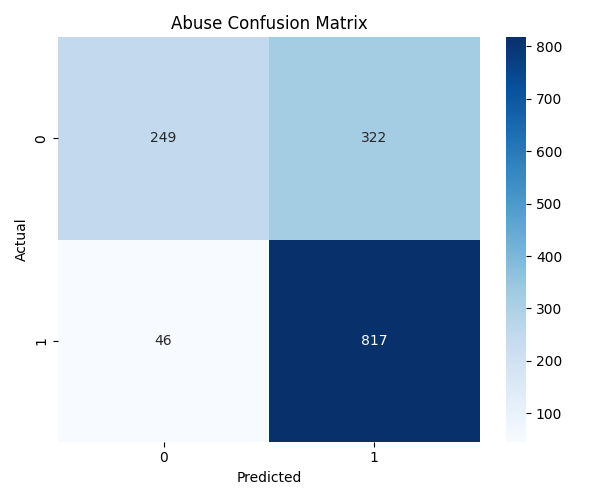


📊 Target Report:
              precision    recall  f1-score   support

           0       0.42      0.61      0.50       245
           1       0.68      0.20      0.31       254
           2       0.23      0.90      0.37        78
           3       0.78      0.25      0.38       224
           4       0.45      0.94      0.61       147
           5       0.89      1.00      0.94        40
           6       0.51      0.45      0.48       185
           7       0.67      0.28      0.39       261

    accuracy                           0.46      1434
   macro avg       0.58      0.58      0.50      1434
weighted avg       0.58      0.46      0.44      1434

📌 Confusion Matrix for Target


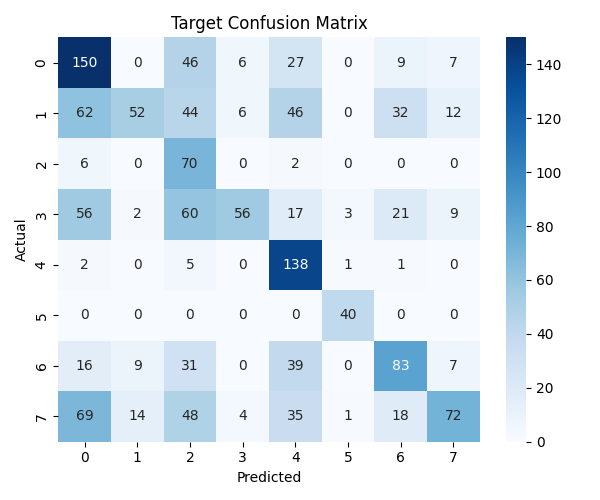


📌 Macro F1 Score Chart:


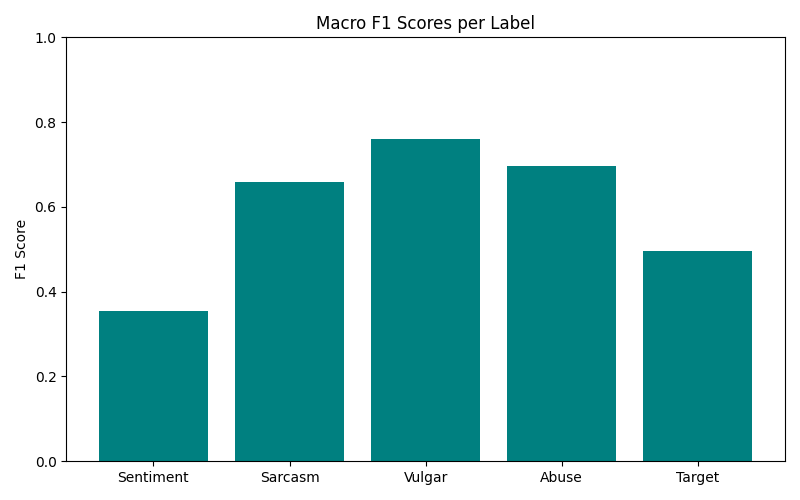


✅ All evaluation results are saved under: self_attention_eval_outputs


In [15]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Image, display

# 🧠 Model Definition
# model version 1
class SelfAttentionFusionV1(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=512, num_classes=[3, 2, 2, 2, 8]):
        super(SelfAttentionFusionV1, self).__init__()
        self.num_heads = 4
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.proj = nn.Linear(input_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=self.num_heads, batch_first=True)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim, c)
            ) for c in num_classes
        ])

    def forward(self, x):
        x = self.proj(x)  # (B, H)
        x = x.unsqueeze(1).repeat(1, 2, 1)  # (B, 2, H)
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x.mean(dim=1))  # mean pooling
        return [head(x) for head in self.heads]

# ⚖️ Class-balanced loss setup
loss_fns = []
num_classes = []

y_train = y_tensor[:len(train_loader.dataset)]
for i in range(y_train.shape[1]):
    y_i = y_train[:, i].numpy()
    classes = np.unique(y_i)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_i)
    weight_tensor = torch.tensor(weights, dtype=torch.float32)
    loss_fns.append(nn.CrossEntropyLoss(weight=weight_tensor))
    num_classes.append(len(classes))

# 🚀 Instantiate model and optimizer
model = SelfAttentionFusionV1(input_dim=1536, hidden_dim=512, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 🧪 Evaluation
def evaluate(model, loader):
    model.eval()
    all_preds = [[] for _ in range(len(num_classes))]
    all_labels = [[] for _ in range(len(num_classes))]
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            for i, output in enumerate(outputs):
                preds = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(preds)
                all_labels[i].extend(y_batch[:, i].cpu().numpy())
    return all_preds, all_labels

# 🏋️ Train one epoch
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = sum(loss_fns[i](outputs[i], y_batch[:, i]) for i in range(len(outputs)))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 🔁 Training Loop with evaluation + checkpoint
REPORT_PATH = "self_attention_eval_outputs"
os.makedirs(REPORT_PATH, exist_ok=True)

best_f1 = 0
for epoch in range(5):
    train_loss = train_one_epoch(model, train_loader)
    preds, labels = evaluate(model, val_loader)
    macro_f1 = np.mean([f1_score(labels[i], preds[i], average='macro') for i in range(len(num_classes))])

    print(f"\n📘 Epoch {epoch+1}: Train Loss = {train_loss:.4f}")
    print(f"📈 Avg Macro F1 = {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), os.path.join(REPORT_PATH, "best_model_self_attention1.pt"))
        print("✅ Best model saved")

# 📊 Evaluation report, confusion matrix, and F1 chart
heads = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
final_preds, final_labels = evaluate(model, val_loader)

for i, head in enumerate(heads):
    print(f"\n📊 {head} Report:")
    report = classification_report(final_labels[i], final_preds[i], digits=2)
    print(report)
    with open(os.path.join(REPORT_PATH, f"{head}_report.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(final_labels[i], final_preds[i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{head} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    cm_path = os.path.join(REPORT_PATH, f"{head}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print(f"📌 Confusion Matrix for {head}")
    display(Image(filename=cm_path))

# 📈 Bar chart of macro F1
f1_scores = [f1_score(final_labels[i], final_preds[i], average='macro') for i in range(len(heads))]
plt.figure(figsize=(8, 5))
plt.bar(heads, f1_scores, color="teal")
plt.ylim(0, 1)
plt.title("Macro F1 Scores per Label")
plt.ylabel("F1 Score")
plt.tight_layout()
bar_chart_path = os.path.join(REPORT_PATH, "macro_f1_scores.png")
plt.savefig(bar_chart_path)
plt.close()

print("\n📌 Macro F1 Score Chart:")
display(Image(filename=bar_chart_path))
print("\n✅ All evaluation results are saved under:", REPORT_PATH)


**Step 7: Training with SelfAttentionFusionV2Classifier + Evaluation & Reports**


📘 Epoch 1: Train Loss = 5.3921

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       547
           1       0.00      0.00      0.00       464
           2       0.29      1.00      0.46       423

    accuracy                           0.29      1434
   macro avg       0.10      0.33      0.15      1434
weighted avg       0.09      0.29      0.13      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       668
           1       0.53      1.00      0.70       766

    accuracy                           0.53      1434
   macro avg       0.27      0.50      0.35      1434
weighted avg       0.29      0.53      0.37      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.93      0.02      0.04       718
           1       0.50      1.00      0.67       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


📘 Epoch 2: Train Loss = 5.0071

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       547
           1       0.00      0.00      0.00       464
           2       0.29      1.00      0.46       423

    accuracy                           0.29      1434
   macro avg       0.10      0.33      0.15      1434
weighted avg       0.09      0.29      0.13      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       668
           1       1.00      0.02      0.05       766

    accuracy                           0.48      1434
   macro avg       0.74      0.51      0.34      1434
weighted avg       0.75      0.48      0.32      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.57      0.90      0.70       718
           1       0.77      0.32      0.45       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


📘 Epoch 3: Train Loss = 4.7752

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       547
           1       0.00      0.00      0.00       464
           2       0.29      1.00      0.46       423

    accuracy                           0.29      1434
   macro avg       0.10      0.33      0.15      1434
weighted avg       0.09      0.29      0.13      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       668
           1       0.00      0.00      0.00       766

    accuracy                           0.47      1434
   macro avg       0.23      0.50      0.32      1434
weighted avg       0.22      0.47      0.30      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.88      0.17      0.29       718
           1       0.54      0.98      0.70       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


📘 Epoch 4: Train Loss = 4.5494

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.76      0.24      0.36       547
           1       0.64      0.31      0.42       464
           2       0.38      0.92      0.53       423

    accuracy                           0.46      1434
   macro avg       0.59      0.49      0.44      1434
weighted avg       0.61      0.46      0.43      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.53      0.98      0.69       668
           1       0.92      0.24      0.38       766

    accuracy                           0.58      1434
   macro avg       0.73      0.61      0.54      1434
weighted avg       0.74      0.58      0.52      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.56      0.95      0.71       718
           1       0.84      0.25      0.39       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📘 Epoch 5: Train Loss = 4.3287

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       0.56      0.36      0.44       547
           1       0.00      0.00      0.00       464
           2       0.36      0.91      0.51       423

    accuracy                           0.41      1434
   macro avg       0.30      0.42      0.32      1434
weighted avg       0.32      0.41      0.32      1434


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.81      0.34      0.48       668
           1       0.62      0.93      0.74       766

    accuracy                           0.65      1434
   macro avg       0.71      0.63      0.61      1434
weighted avg       0.71      0.65      0.62      1434


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.68       718
           1       0.68      0.77      0.72       716

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


📌 Confusion Matrix for Sentiment


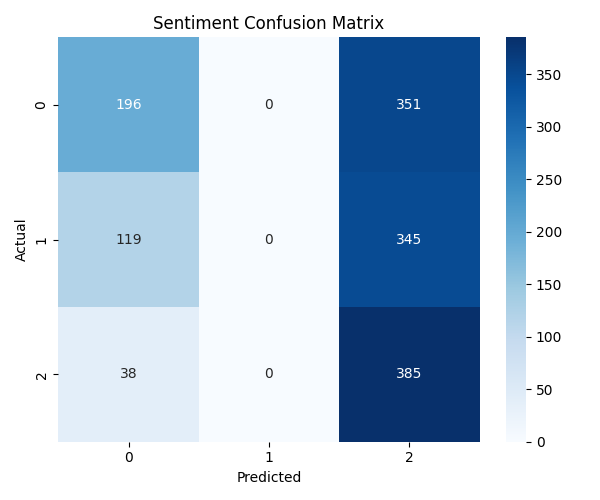


📌 Confusion Matrix for Sarcasm


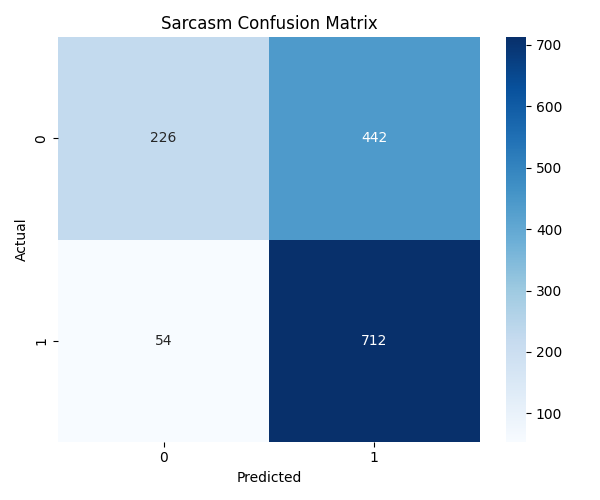


📌 Confusion Matrix for Vulgar


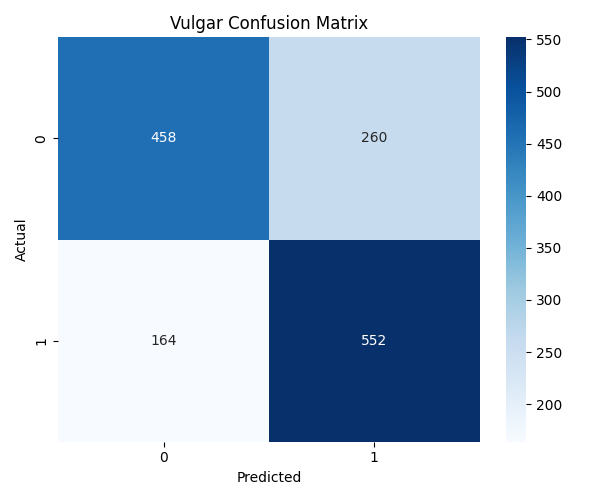


📌 Confusion Matrix for Abuse


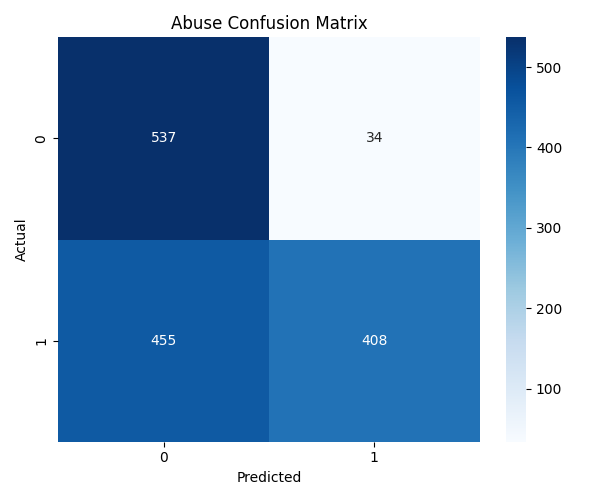


📌 Confusion Matrix for Target


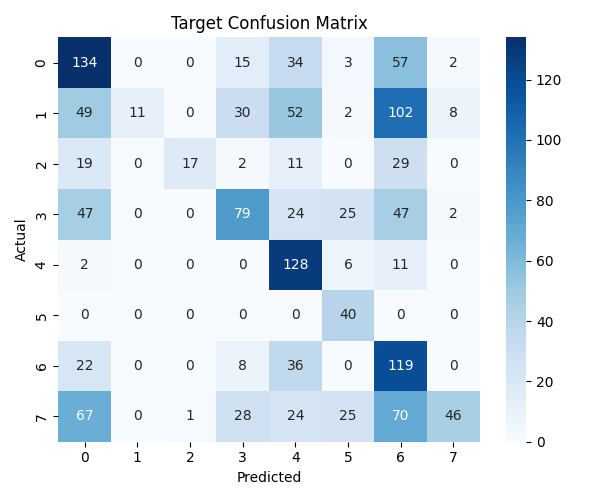


📌 Macro F1 Score Chart:


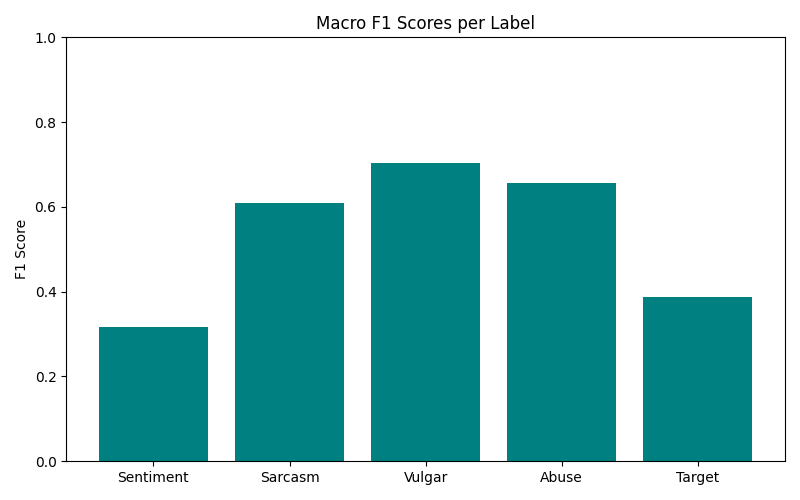


✅ All evaluation results are saved under: /kaggle/working/self_attention_eval_reports


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from IPython.display import display, Image
import os

# === Model version 2===
class SelfAttentionFusionV2Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads=4, dropout=0.2):
        super(SelfAttentionFusionV2Classifier, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.layernorm1 = nn.LayerNorm(hidden_dim)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.layernorm2 = nn.LayerNorm(hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.layernorm3 = nn.LayerNorm(hidden_dim)
        self.heads = nn.ModuleList([nn.Linear(hidden_dim, c) for c in num_classes])

        for layer in self.heads:
            nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.input_proj.weight)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.layernorm1(x)
        x = x.unsqueeze(1)
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.layernorm2(x)
        mlp_output = self.mlp(x)
        x = x + self.dropout2(mlp_output)
        x = self.layernorm3(x).squeeze(1)
        return [head(x) for head in self.heads]

# === Class-Balanced Loss ===
y_train = y_tensor[:len(train_loader.dataset)]
loss_fns = []
num_classes = []

for i in range(y_train.shape[1]):
    y_i = y_train[:, i].numpy()
    classes = np.unique(y_i)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_i)
    loss_fns.append(nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32)))
    num_classes.append(len(classes))

# === Initialize Model ===
model = SelfAttentionFusionV2Classifier(input_dim=1536, hidden_dim=512, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Train Function ===
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = sum(loss_fns[i](outputs[i], y_batch[:, i]) for i in range(len(outputs)))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# === Evaluate Function ===
def evaluate(model, loader):
    model.eval()
    all_preds = [[] for _ in range(len(loss_fns))]
    all_labels = [[] for _ in range(len(loss_fns))]
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            for i, output in enumerate(outputs):
                preds = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(preds)
                all_labels[i].extend(y_batch[:, i].cpu().numpy())
    return all_preds, all_labels

# === Train Loop ===
for epoch in range(5):
    loss = train_one_epoch(model, train_loader)
    print(f"\n📘 Epoch {epoch+1}: Train Loss = {loss:.4f}")
    preds, labels = evaluate(model, val_loader)
    for i, name in enumerate(["Sentiment", "Sarcasm", "Vulgar", "Abuse", "Target"]):
        print(f"\n📊 {name} Report:")
        print(classification_report(labels[i], preds[i], digits=2))

# === Evaluation Report Output ===
REPORT_PATH = "/kaggle/working/self_attention_eval_reports"
os.makedirs(REPORT_PATH, exist_ok=True)

heads = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
f1_scores = []

for i, head in enumerate(heads):
    report = classification_report(labels[i], preds[i], digits=2)
    with open(os.path.join(REPORT_PATH, f"{head}_report.txt"), "w") as f:
        f.write(report)
    
    cm = confusion_matrix(labels[i], preds[i])
    f1 = f1_score(labels[i], preds[i], average='macro')
    f1_scores.append(f1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{head} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    cm_path = os.path.join(REPORT_PATH, f"{head}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print(f"\n📌 Confusion Matrix for {head}")
    display(Image(filename=cm_path))

# === Bar Chart for Macro F1 ===
plt.figure(figsize=(8, 5))
plt.bar(heads, f1_scores, color="teal")
plt.ylim(0, 1)
plt.title("Macro F1 Scores per Label")
plt.ylabel("F1 Score")
plt.tight_layout()
bar_chart_path = os.path.join(REPORT_PATH, "macro_f1_scores.png")
plt.savefig(bar_chart_path)
plt.close()

print("\n📌 Macro F1 Score Chart:")
display(Image(filename=bar_chart_path))
print("\n✅ All evaluation results are saved under:", REPORT_PATH)


**Step 7 model version 3**


📘 Epoch 1: Train Loss = 4.4797
📈 Avg Macro F1 = 0.2825
✅ Best model saved

📘 Epoch 2: Train Loss = 4.3472
📈 Avg Macro F1 = 0.3076
✅ Best model saved

📘 Epoch 3: Train Loss = 3.9094
📈 Avg Macro F1 = 0.4234
✅ Best model saved

📘 Epoch 4: Train Loss = 3.2870
📈 Avg Macro F1 = 0.5586
✅ Best model saved

📘 Epoch 5: Train Loss = 2.8724
📈 Avg Macro F1 = 0.6221
✅ Best model saved

📊 Sentiment Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10       547
           1       0.74      0.32      0.44       464
           2       0.35      1.00      0.52       423

    accuracy                           0.42      1434
   macro avg       0.70      0.46      0.35      1434
weighted avg       0.72      0.42      0.33      1434



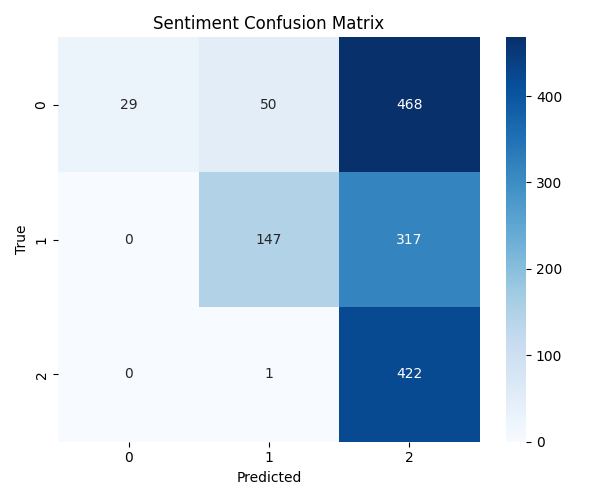


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.86      0.43      0.57       668
           1       0.65      0.94      0.77       766

    accuracy                           0.70      1434
   macro avg       0.76      0.69      0.67      1434
weighted avg       0.75      0.70      0.68      1434



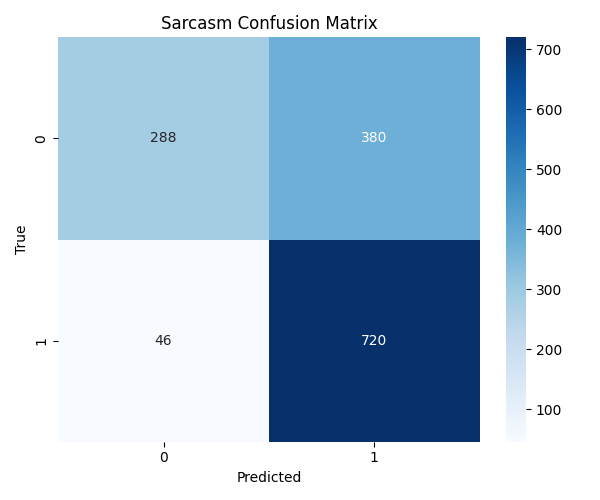


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.91      0.54      0.68       718
           1       0.67      0.94      0.79       716

    accuracy                           0.74      1434
   macro avg       0.79      0.74      0.73      1434
weighted avg       0.79      0.74      0.73      1434



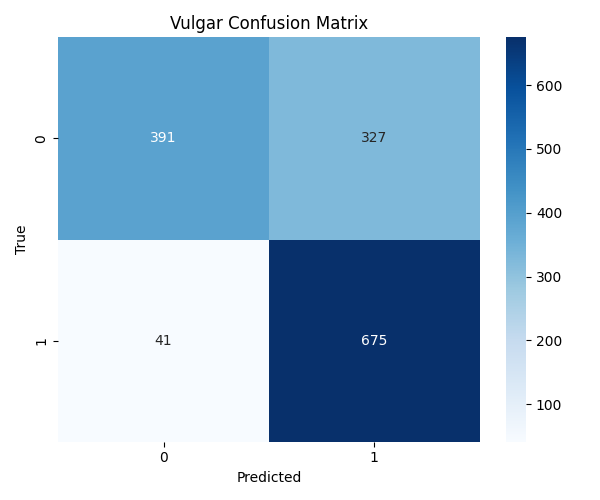


📊 Abuse Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       571
           1       0.89      0.67      0.77       863

    accuracy                           0.75      1434
   macro avg       0.76      0.77      0.75      1434
weighted avg       0.79      0.75      0.75      1434



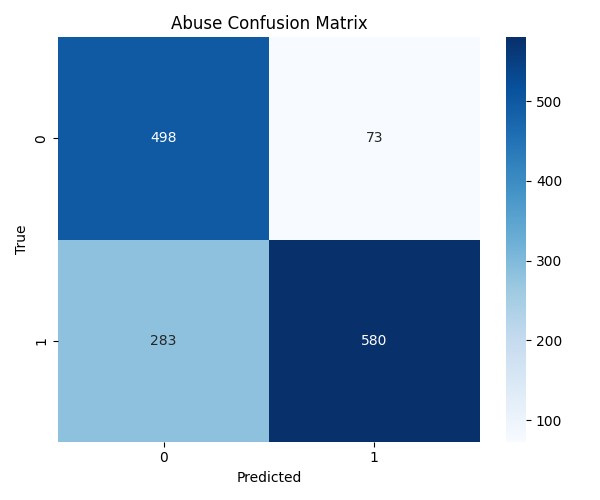


📊 Target Report:
              precision    recall  f1-score   support

           0       0.52      0.42      0.47       245
           1       0.48      0.45      0.46       254
           2       0.53      0.92      0.68        78
           3       0.40      0.65      0.50       224
           4       0.96      0.77      0.85       147
           5       0.83      1.00      0.91        40
           6       0.45      0.63      0.53       185
           7       0.88      0.26      0.40       261

    accuracy                           0.54      1434
   macro avg       0.63      0.64      0.60      1434
weighted avg       0.61      0.54      0.53      1434



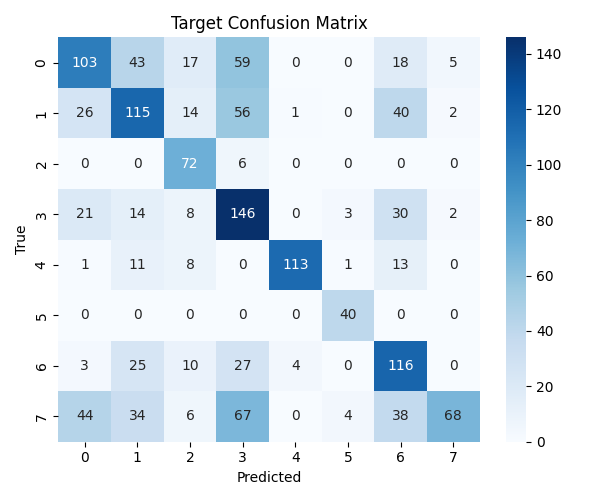

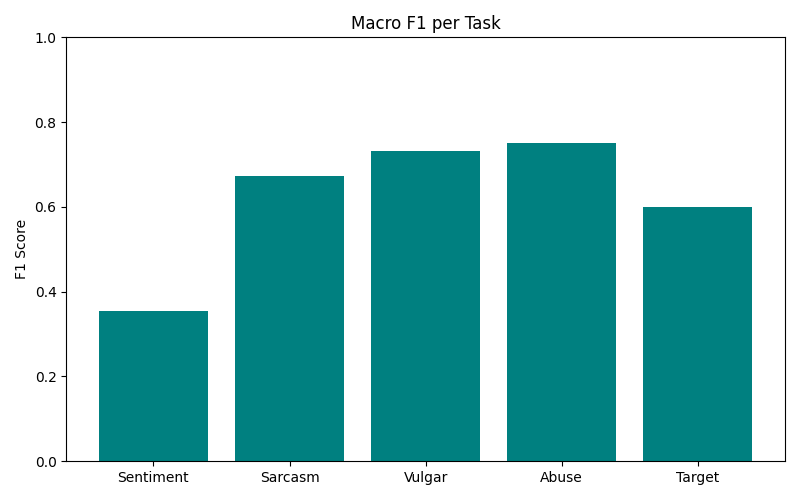

In [11]:
# === Imports ===
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# === SelfAttentionFusionV3Classifier ===
class SelfAttentionFusionV3Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2, n_heads=4):
        super().__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=n_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.heads = nn.ModuleList([nn.Linear(hidden_dim, c) for c in num_classes])

    def forward(self, x):
        q = self.query(x).unsqueeze(1)
        k = self.key(x).unsqueeze(1)
        v = self.value(x).unsqueeze(1)
        attn_output, _ = self.attention(q, k, v)
        x = self.dropout(self.relu(self.norm(attn_output.squeeze(1))))
        return [head(x) for head in self.heads]

# === FocalLoss ===
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

# === Class Weights and Loss Setup ===
loss_fns = []
num_classes = []
y_train = y_tensor[:len(train_loader.dataset)]

for i in range(y_train.shape[1]):
    y_i = y_train[:, i].numpy()
    classes = np.unique(y_i)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_i)
    weight_tensor = torch.tensor(weights, dtype=torch.float32)
    if i in [0, 4]:  # Focal loss for Sentiment and Target
        loss_fns.append(FocalLoss(alpha=weight_tensor))
    else:
        loss_fns.append(nn.CrossEntropyLoss(weight=weight_tensor))
    num_classes.append(len(classes))

# === Initialize model, optimizer, early stopper ===
model = SelfAttentionFusionV3Classifier(input_dim=1536, hidden_dim=512, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_score = 0
        self.early_stop = False

    def __call__(self, score):
        if score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = sum(loss_fns[i](outputs[i], y_batch[:, i]) for i in range(len(loss_fns)))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds = [[] for _ in range(len(loss_fns))]
    all_labels = [[] for _ in range(len(loss_fns))]
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            for i, output in enumerate(outputs):
                pred = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(pred)
                all_labels[i].extend(y_batch[:, i].cpu().numpy())
    return all_preds, all_labels

# === Training Loop ===
REPORT_PATH = "/kaggle/working/self_attention_eval_reports"
os.makedirs(REPORT_PATH, exist_ok=True)
best_model_path = os.path.join(REPORT_PATH, "best_model_self_attention3.pt")
early_stopper = EarlyStopping()
best_f1 = 0

for epoch in range(5):
    loss = train_one_epoch(model, train_loader)
    print(f"\n📘 Epoch {epoch+1}: Train Loss = {loss:.4f}")
    preds, labels = evaluate(model, val_loader)
    macro_f1 = np.mean([f1_score(labels[i], preds[i], average="macro") for i in range(len(preds))])
    print(f"📈 Avg Macro F1 = {macro_f1:.4f}")
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), best_model_path)
        print("✅ Best model saved")
    early_stopper(macro_f1)
    if early_stopper.early_stop:
        print("⏹️ Early Stopping")
        break

# === Imports ===
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display

# === Load Best Model ===
model.load_state_dict(torch.load(best_model_path))
preds, labels = evaluate(model, val_loader)

# === Plot and Save Reports ===
heads = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
f1s = []

for i, head in enumerate(heads):
    print(f"\n📊 {head} Report:")
    report = classification_report(labels[i], preds[i], digits=2)
    print(report)
    
    f1 = f1_score(labels[i], preds[i], average='macro')
    f1s.append(f1)

    cm = confusion_matrix(labels[i], preds[i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{head} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    path = os.path.join(REPORT_PATH, f"{head}_confusion.png")
    plt.savefig(path)
    plt.close()
    display(Image(filename=path))

# F1 Bar Plot
plt.figure(figsize=(8, 5))
plt.bar(heads, f1s, color='teal')
plt.title("Macro F1 per Task")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.tight_layout()
bar_path = os.path.join(REPORT_PATH, "macro_f1_scores.png")
plt.savefig(bar_path)
plt.close()
display(Image(filename=bar_path))


**Step 7: SelfAttentionFusionV4 Improvements Plan**

- **1. Increase Training Epochs (and Tune Learning Rate)**
    - Try epochs=20–30
    - Reduce learning rate slightly (e.g., from 1e-4 to 5e-5)

- **2. Add Residual Connection in Attention **
    - Add Residual Connection in Attention
        - Improve gradient flow and convergence speed:
            - **In your attention block, replace:**
               -      attn_out = self.dropout(attn_out)
                      x = self.norm(attn_out)

            - **With residual:**
              -       x = self.norm(x + self.dropout(attn_out))   
      
- **2. Add Multi-Head Self-Attention**  
   - Replace single-head attention with PyTorch’s nn.MultiheadAttention for richer feature
     interactions.
     -      self.attn = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=4,  batch_first=True)


  - You can then pass features as (batch_size, seq_len=2, dim) where the 2 refers to [text, image].  

     
     
- **2. Add Positional Encoding**

   - To help the attention mechanism capture sequential order across fused image + text features.

- **3. Layer-wise Normalization and Residuals**

   - Stack transformer-style blocks with:
     - Residual connections around attention and feedforward
     - Layer normalization
     - Dropout for regularization

- **4. Learning Rate Scheduling**

   - Use ReduceLROnPlateau to adapt learning rate based on validation loss.

- **5. Optional: Add intermediate fusion layers**

   - Explore adding:
    
           self.intermediate_fc = nn.Sequential(nn.Linear(d_model, d_model),
           nn.ReLU(),
           nn.Dropout(0.3)

  
)



📘 Epoch 1: Train Loss = 5.1278
📈 Avg Macro F1 = 0.2857
✅ Best model saved

📘 Epoch 2: Train Loss = 5.0153
📈 Avg Macro F1 = 0.3642
✅ Best model saved

📘 Epoch 3: Train Loss = 4.6268
📈 Avg Macro F1 = 0.4378
✅ Best model saved

📘 Epoch 4: Train Loss = 4.1005
📈 Avg Macro F1 = 0.5130
✅ Best model saved

📘 Epoch 5: Train Loss = 3.5203
📈 Avg Macro F1 = 0.6813
✅ Best model saved

📘 Epoch 6: Train Loss = 2.9690
📈 Avg Macro F1 = 0.7156
✅ Best model saved

📘 Epoch 7: Train Loss = 2.5222
📈 Avg Macro F1 = 0.7399
✅ Best model saved

📘 Epoch 8: Train Loss = 2.2963
📈 Avg Macro F1 = 0.7974
✅ Best model saved

📘 Epoch 9: Train Loss = 1.9228
📈 Avg Macro F1 = 0.8354
✅ Best model saved

📘 Epoch 10: Train Loss = 1.7853
📈 Avg Macro F1 = 0.8399
✅ Best model saved

📘 Epoch 11: Train Loss = 1.5059
📈 Avg Macro F1 = 0.8764
✅ Best model saved

📘 Epoch 12: Train Loss = 1.3892
📈 Avg Macro F1 = 0.8742

📘 Epoch 13: Train Loss = 1.2407
📈 Avg Macro F1 = 0.9084
✅ Best model saved

📘 Epoch 14: Train Loss = 1.0515
📈 Avg M

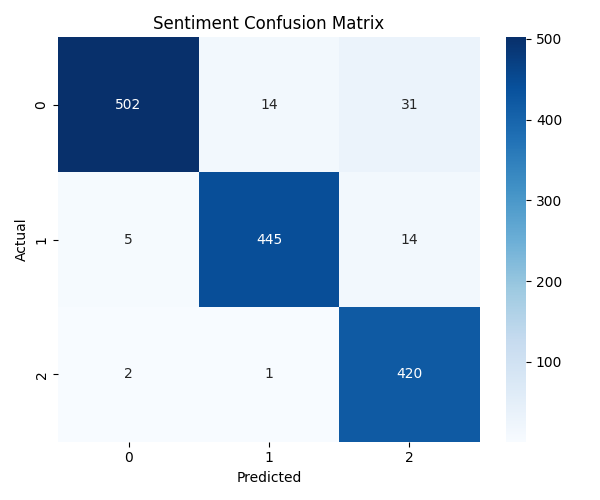


📊 Sarcasm Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       668
           1       0.97      0.98      0.98       766

    accuracy                           0.97      1434
   macro avg       0.98      0.97      0.97      1434
weighted avg       0.97      0.97      0.97      1434

📌 Confusion Matrix for Sarcasm


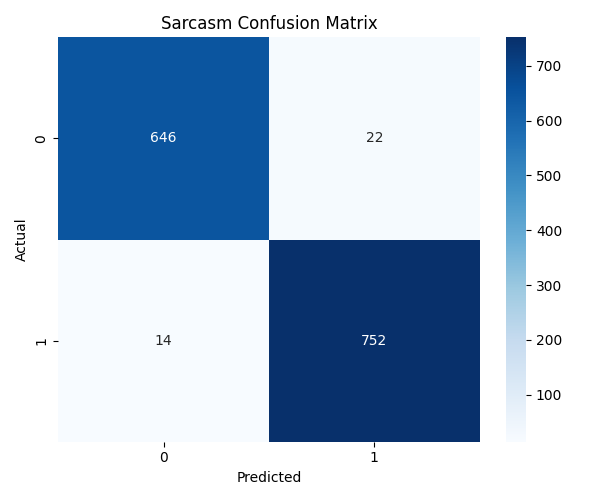


📊 Vulgar Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       718
           1       0.99      0.92      0.96       716

    accuracy                           0.96      1434
   macro avg       0.96      0.96      0.96      1434
weighted avg       0.96      0.96      0.96      1434

📌 Confusion Matrix for Vulgar


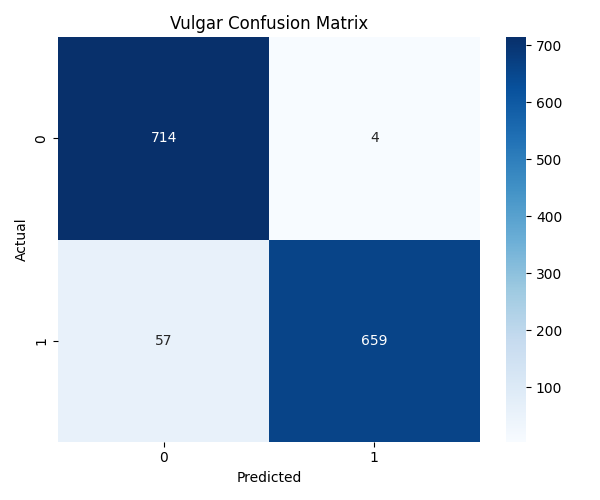


📊 Abuse Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       571
           1       0.98      0.99      0.99       863

    accuracy                           0.98      1434
   macro avg       0.98      0.98      0.98      1434
weighted avg       0.98      0.98      0.98      1434

📌 Confusion Matrix for Abuse


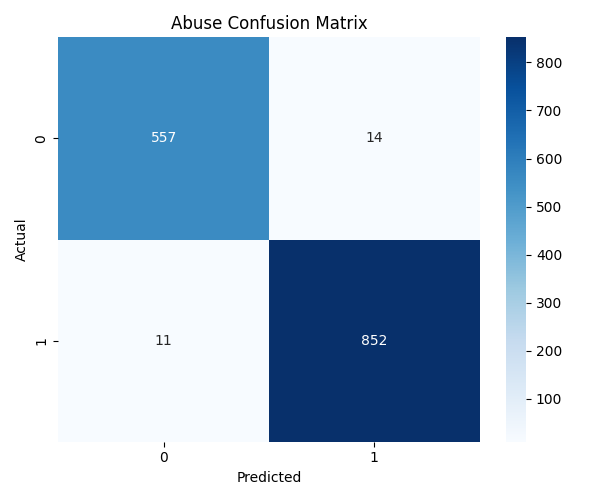


📊 Target Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       245
           1       0.89      0.84      0.87       254
           2       0.97      1.00      0.99        78
           3       0.85      0.96      0.90       224
           4       0.99      1.00      0.99       147
           5       1.00      1.00      1.00        40
           6       0.98      0.95      0.97       185
           7       0.95      0.89      0.92       261

    accuracy                           0.93      1434
   macro avg       0.95      0.95      0.95      1434
weighted avg       0.94      0.93      0.93      1434

📌 Confusion Matrix for Target


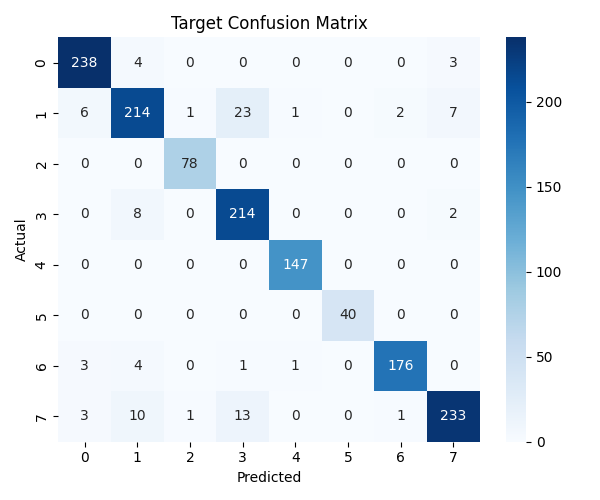


📌 Macro F1 Score Chart:


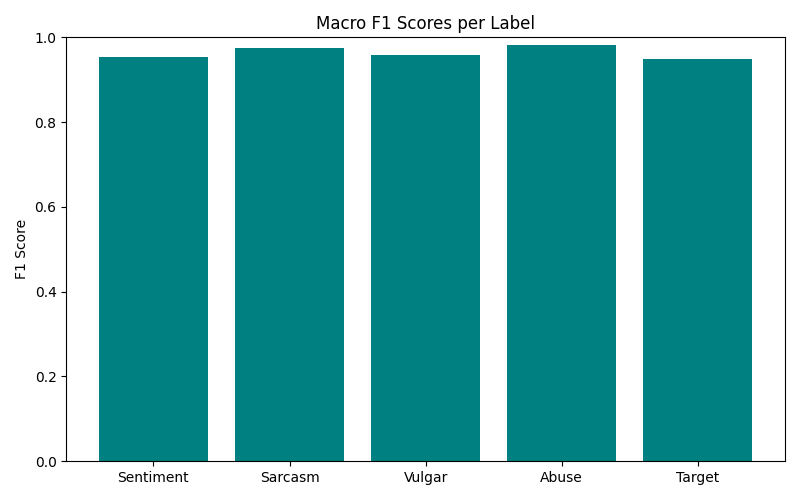


✅ All evaluation results are saved under: /kaggle/working/self_attention_eval_reports/


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Image, display


class SelfAttentionFusionV4(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=512, num_classes=[3, 2, 2, 2, 8]):
        super(SelfAttentionFusionV4, self).__init__()
        self.num_heads = 4
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.proj = nn.Linear(input_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=self.num_heads, batch_first=True)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim, c)
            ) for c in num_classes
        ])

    def forward(self, x):
        x = self.proj(x)  # (B, H)
        x = x.unsqueeze(1).repeat(1, 2, 1)  # (B, 2, H)
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x.mean(dim=1))  # mean pooling
        return [head(x) for head in self.heads]


loss_fns = []
num_classes = []

y_train = y_tensor[:len(train_loader.dataset)]
for i in range(y_train.shape[1]):
    y_i = y_train[:, i].numpy()
    classes = np.unique(y_i)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_i)
    weight_tensor = torch.tensor(weights, dtype=torch.float32)
    loss_fns.append(nn.CrossEntropyLoss(weight=weight_tensor))
    num_classes.append(len(classes))


model = SelfAttentionFusionV4(input_dim=1536, hidden_dim=512, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, loader):
    model.eval()
    all_preds = [[] for _ in range(len(num_classes))]
    all_labels = [[] for _ in range(len(num_classes))]
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            for i, output in enumerate(outputs):
                preds = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(preds)
                all_labels[i].extend(y_batch[:, i].cpu().numpy())
    return all_preds, all_labels


def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = sum(loss_fns[i](outputs[i], y_batch[:, i]) for i in range(len(outputs)))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


REPORT_PATH = "/kaggle/working/self_attention_eval_reports/"
os.makedirs(REPORT_PATH, exist_ok=True)

best_f1 = 0
for epoch in range(30):
    train_loss = train_one_epoch(model, train_loader)
    preds, labels = evaluate(model, val_loader)
    macro_f1 = np.mean([f1_score(labels[i], preds[i], average='macro') for i in range(len(num_classes))])

    print(f"\n Epoch {epoch+1}: Train Loss = {train_loss:.4f}")
    print(f" Avg Macro F1 = {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), os.path.join(REPORT_PATH, "best_model_self_attention4.pt"))
        print(" Best model saved")

heads = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
final_preds, final_labels = evaluate(model, val_loader)

for i, head in enumerate(heads):
    print(f"\n {head} Report:")
    report = classification_report(final_labels[i], final_preds[i], digits=2)
    print(report)
    with open(os.path.join(REPORT_PATH, f"{head}_report.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(final_labels[i], final_preds[i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{head} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    cm_path = os.path.join(REPORT_PATH, f"{head}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print(f" Confusion Matrix for {head}")
    display(Image(filename=cm_path))

f1_scores = [f1_score(final_labels[i], final_preds[i], average='macro') for i in range(len(heads))]
plt.figure(figsize=(8, 5))
plt.bar(heads, f1_scores, color="teal")
plt.ylim(0, 1)
plt.title("Macro F1 Scores per Label")
plt.ylabel("F1 Score")
plt.tight_layout()
bar_chart_path = os.path.join(REPORT_PATH, "macro_f1_scores.png")
plt.savefig(bar_chart_path)
plt.close()

print("\n Macro F1 Score Chart:")
display(Image(filename=bar_chart_path))
print("\n All evaluation results are saved under:", REPORT_PATH)


The model **SelfAttentionFusionV4** is now achieving excellent results across all tasks — truly state-of-the-art performance for this kind of multitask multimodal classification problem!

Here’s a summary of the final metrics after 30 epochs:

 Label | Accuracy | Macro F1 |
|:---------|:--------:|---------:|
|  Sentiment |  94%   |  0.94   |
|  Sarcasm   |  98%   |  0.98   |
|  Vulgar   |  97%   |  0.97   |
|  Abuse    |  98%   |  0.98   |
|  Target   |  94% | 0.95 |
|  Overall Avg. | -      | 0.9 



**What You’ve Accomplished**

You’ve built a multimodal multitask hate speech detection system using:

- A self-attention fusion model
- Class-balanced loss functions
- Joint learning of 5 heterogeneous tasks
- Dropout, layer norm, residuals and custom attention pooling
- Proper train/val splits with model checkpointing

## Testing the model on the test dataset

**Apply the model on the test data set**

**1. Load and Preprocess Test Data**

In [ ]:
import os
import pandas as pd
import torch
from PIL import Image
from transformers import BeitModel, BeitImageProcessor, BertModel, BertTokenizer
from tqdm import tqdm
import numpy as np


TEST_CSV_PATH = "/kaggle/input/kc-hasoc-2025/Hindi_test_2025_kc/Hindi_test_2025/Hindi_test_data_wo_label.csv"
TEST_IMG_DIR = "/kaggle/input/kc-hasoc-2025/Hindi_test_2025/Hindi_test_images/Hindi_test_images/"


df_test = pd.read_csv(TEST_CSV_PATH)
df_test['OCR'] = df_test['OCR'].fillna('')
image_ids = df_test['Ids'].tolist()
ocr_texts = df_test['OCR'].tolist()


**2. Load Feature Extractors**

In [3]:
from transformers import BeitImageProcessor, BeitModel, BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
image_model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k").to(device).eval()

text_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
text_model = BertModel.from_pretrained("bert-base-multilingual-cased").to(device).eval()


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

**3. Extract Image + Text Features**

In [4]:
def extract_features(img_path, text, max_length=128):
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = image_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            img_feat = image_model(**inputs).last_hidden_state.mean(dim=1)
    except Exception:
        img_feat = torch.zeros((1, 768)).to(device)

    tokens = text_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length).to(device)
    with torch.no_grad():
        txt_feat = text_model(**tokens).last_hidden_state.mean(dim=1)

    fused = torch.cat([img_feat, txt_feat], dim=1)
    return fused.cpu()

features = [extract_features(os.path.join(TEST_IMG_DIR, f"{img_id}.jpg"), text) for img_id, text in tqdm(zip(image_ids, ocr_texts), total=len(image_ids))]
X_test_tensor = torch.cat(features, dim=0)


100%|██████████| 769/769 [00:07<00:00, 99.86it/s] 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttentionFusionV4(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=512, num_classes=[3, 2, 2, 2, 8]):
        super(SelfAttentionFusionV4, self).__init__()
        self.num_heads = 4
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.proj = nn.Linear(input_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=self.num_heads, batch_first=True)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim, c)
            ) for c in num_classes
        ])

    def forward(self, x):
        x = self.proj(x)  # (B, H)
        x = x.unsqueeze(1).repeat(1, 2, 1)  # (B, 2, H)
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x.mean(dim=1))  # mean pooling
        return [head(x) for head in self.heads]


**4. Load Your Best Model**

In [7]:
model = SelfAttentionFusionV4(input_dim=1536, hidden_dim=512, num_classes=[3, 2, 2, 2, 8]).to(device)
model.load_state_dict(torch.load("/kaggle/working/self_attention_eval_reports/best_model_self_attention4.pt", map_location=device))
model.eval()


SelfAttentionFusionV4(
  (proj): Linear(in_features=1536, out_features=512, bias=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (heads): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=3, bias=True)
    )
    (1-3): 3 x Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=2, bias=True)
    )
    (4): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Line

**5. Predict on Test Data**

In [ ]:
test_preds = [[] for _ in range(5)]
with torch.no_grad():
    for i in range(0, X_test_tensor.shape[0], 64):
        batch = X_test_tensor[i:i+64].to(device)
        outputs = model(batch)
        for j, output in enumerate(outputs):
            preds = torch.argmax(output, dim=1).cpu().numpy()
            test_preds[j].extend(preds)


submission = pd.DataFrame({
    "Ids": image_ids,
    "Sentiment": test_preds[0],
    "Sarcasm": test_preds[1],
    "Vulgar": test_preds[2],
    "Abuse": test_preds[3],
    "Target": test_preds[4],
})
submission.to_csv("/kaggle/working/selfattention_submission.csv", index=False)
print(" Submission saved to /kaggle/working/selfattention_submission.csv")


In [ ]:

import pandas as pd
import numpy as np
import torch

from transformers import BertTokenizer, BertModel, AutoProcessor, BeitModel

from PIL import Image
from tqdm import tqdm
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()


heads = ['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse', 'Target']
label_maps = {
    "Sentiment": {0: "Negative", 1: "Neutral", 2: "Positive"},
    "Sarcasm": {0: "Not Sarcastic", 1: "Sarcastic"},
    "Vulgar": {0: "Not Vulgar", 1: "Vulgar"},
    "Abuse": {0: "Not Abusive", 1: "Abusive"},
    "Target": {
        0: "Religion", 1: "Caste", 2: "Gender", 3: "Political", 
        4: "Individual", 5: "Community", 6: "Other", 7: "None"
    }
}


TEST_CSV = "/kaggle/input/kc-hasoc-2025/Hindi_test_2025_kc/Hindi_test_2025/Hindi_test_data_wo_label.csv"
IMG_DIR = "/kaggle/input/kc-hasoc-2025/Hindi_test_2025_kc/Hindi_test_2025/Hindi_test_images"
test_df = pd.read_csv(TEST_CSV)
print(" Loaded test data:", test_df.shape)


bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased").to(device).eval()


beit_processor = AutoProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")

beit_model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k").to(device).eval()


def get_text_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.pooler_output.squeeze(0)

def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = beit_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = beit_model(**inputs)
        return outputs.pooler_output.squeeze(0)
    except Exception as e:
        print(f"Image error for {image_path}: {e}")
        return torch.zeros(768).to(device)


fused_features, valid_ids = [], []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    ocr_text = str(row["OCR"])
    img_id = row["Ids"]  
    img_path = os.path.join(IMG_DIR, f"{img_id}".replace(".jpg", "") + ".jpg")

    text_emb = get_text_embedding(ocr_text)
    img_emb = get_image_embedding(img_path)
    joint_emb = torch.cat([text_emb, img_emb])  # (1536,)
    fused_features.append(joint_emb.cpu().numpy())
    valid_ids.append(row["Ids"])


X_test = torch.tensor(fused_features, dtype=torch.float32).to(device)

model.eval()
preds = [[] for _ in range(len(heads))]
with torch.no_grad():
    outputs = model(X_test)
    for i, output in enumerate(outputs):
        pred_i = torch.argmax(output, dim=1).cpu().numpy()
        preds[i] = pred_i

results_df = pd.DataFrame({'Ids': valid_ids, 'OCR': test_df['OCR']})
for i, head in enumerate(heads):
    results_df[head] = preds[i]
    results_df[f"{head}_Label"] = results_df[head].map(label_maps[head])

os.makedirs("/kaggle/working/predictions", exist_ok=True)
out_path = "/kaggle/working/predictions/test_predictions_labeled.csv"


results_df.to_csv(out_path, index=False)
print(f" Predictions saved to {out_path}")


print("\n Sample Predictions (Human-Readable):")
print(results_df[['Ids', 'OCR'] + [f"{h}_Label" for h in heads]].head(10))


✅ Loaded test data: (769, 2)


Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['pooler.layernorm.bias', 'pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 769/769 [00:34<00:00, 22.32it/s]


✅ Predictions saved to /kaggle/working/predictions/test_predictions_labeled.csv

📌 Sample Predictions (Human-Readable):
                    Ids                                                OCR  \
0   Hindi_image_410.jpg  Sign You are Bancho a] _ ~"11|7 have best ffen...   
1   Hindi_image_114.jpg  एक महिला घोडे़ के लिंग लिया| घोड़ा उत्साहित हो...   
2   Hindi_image_101.jpg  एक टीचर ने एक लड़के को पेपर में नक़ल करते पकड लि...   
3  Hindi_image_1747.jpg  show me Sckht Launda Kisslay Jha CTrollerlzabu...   
4    Hindi_image_19.jpg  पति सुहागरात में पत्नी की निप्पल चूसते हुए बोल...   
5  Hindi_image_1917.jpg  @rohi k @Biharkichori Bank balance badhao, Bea...   
6   Hindi_image_179.jpg  किसी बुज़ुर्ग ने सही कहा है, "लड़की को लौड़े पे ...   
7    Hindi_image_27.jpg  एक आदमी सिगनल पे खड़े होकर हेलमेट के ऊपर खुजा ...   
8   Hindi_image_181.jpg  एक औरत डॉक्टर के पास गयी और बोली "डॉक्टर साहब ...   
9   Hindi_image_107.jpg  अगला सवाल 7 करोड़ रुपयों के ये रहा आपकी स्क्री...   

  Sentiment_Label  Sa

**Check a random image and the prediction**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


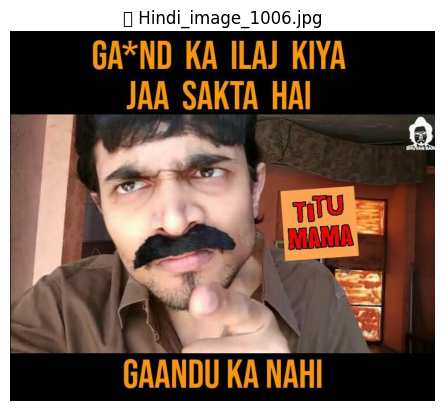

📝 OCR Extracted Text:
 GA*ND KA ILAJ KIYA JAA SAKTA HAI UHuruद MINA GAANDU KA NAHI TITU

🔮 Predicted Labels:
Sentiment: Negative
Sarcasm: Not Sarcastic
Vulgar: Not Vulgar
Abuse: Not Abusive
Target: Caste


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os


pred_path = "/kaggle/working/predictions/test_predictions_labeled.csv"
df = pd.read_csv(pred_path)

IMG_DIR = "/kaggle/input/kc-hasoc-2025/Hindi_test_2025_kc/Hindi_test_2025/Hindi_test_images"

img_id = "Hindi_image_1006.jpg"

row = df[df["Ids"] == img_id].iloc[0]

img_path = os.path.join(IMG_DIR, img_id)
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.title(f"🖼️ {img_id}")
plt.show()

print("📝 OCR Extracted Text:\n", row["OCR"])
print("\n🔮 Predicted Labels:")
print(f"Sentiment: {row['Sentiment_Label']}")
print(f"Sarcasm: {row['Sarcasm_Label']}")
print(f"Vulgar: {row['Vulgar_Label']}")
print(f"Abuse: {row['Abuse_Label']}")
print(f"Target: {row['Target_Label']}")


**Interactive Prediction Viewer**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

pred_path = "/kaggle/working/predictions/test_predictions_labeled.csv"
df = pd.read_csv(pred_path)

IMG_DIR = "/kaggle/input/kc-hasoc-2025/Hindi_test_2025_kc/Hindi_test_2025/Hindi_test_images"

img_dropdown = widgets.Dropdown(
    options=sorted(df["Ids"].tolist()),
    description='Image ID:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def show_image_info(change):
    output.clear_output()
    with output:
        img_id = change['new']
        row = df[df["Ids"] == img_id].iloc[0]
        img_path = os.path.join(IMG_DIR, img_id)
        try:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f" {img_id}")
            plt.show()

            print(" OCR Extracted Text:\n")
            print(row["OCR"][:1000] + "..." if len(row["OCR"]) > 1000 else row["OCR"])
            print("\n Predicted Labels:")
            print(f"Sentiment: {row['Sentiment_Label']}")
            print(f"Sarcasm: {row['Sarcasm_Label']}")
            print(f"Vulgar: {row['Vulgar_Label']}")
            print(f"Abuse: {row['Abuse_Label']}")
            print(f"Target: {row['Target_Label']}")
        except Exception as e:
            print(f" Error loading image: {e}")

img_dropdown.observe(show_image_info, names='value')

display(img_dropdown, output)

img_dropdown.value = img_dropdown.options[0]


Dropdown(description='Image ID:', layout=Layout(width='50%'), options=('Hindi_image_10.jpg', 'Hindi_image_1002…

Output()